<a href="https://colab.research.google.com/github/Ekram49/DS-Unit-2-Applied-Modeling/blob/master/Ekram_LS_DS_233_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/Ekram49/DS-Unit-1-Build/master/ContinousDataset.csv')
df.head()

,Unnamed: 0,Scorecard,Team 1,Team 2,Margin,Ground,Match Date,Winner,Host_Country,Venue_Team1,Venue_Team2,Innings_Team1,Innings_Team2
0,0,ODI # 1,Australia,England,Winner2ndInning,Melbourne,"Jan 5, 1971",Australia,Australia,Home,Away,Second,First
1,1,ODI # 2,England,Australia,Winner2ndInning,Manchester,"Aug 24, 1972",England,England,Home,Away,Second,First
2,2,ODI # 3,England,Australia,Winner2ndInning,Lord's,"Aug 26, 1972",Australia,England,Home,Away,First,Second
3,3,ODI # 4,England,Australia,Winner2ndInning,Birmingham,"Aug 28, 1972",England,England,Home,Away,Second,First
4,4,ODI # 5,New Zealand,Pakistan,Winner1stInning,Christchurch,"Feb 11, 1973",New Zealand,New Zealand,Home,Away,First,Second


In [3]:
df = df.rename(columns={"Team 1": "Team_1", "Team 2": "Team_2",
                   "Team 1": "Team_1","Match Date":"Match_Date"})
df.head()

,Unnamed: 0,Scorecard,Team_1,Team_2,Margin,Ground,Match_Date,Winner,Host_Country,Venue_Team1,Venue_Team2,Innings_Team1,Innings_Team2
0,0,ODI # 1,Australia,England,Winner2ndInning,Melbourne,"Jan 5, 1971",Australia,Australia,Home,Away,Second,First
1,1,ODI # 2,England,Australia,Winner2ndInning,Manchester,"Aug 24, 1972",England,England,Home,Away,Second,First
2,2,ODI # 3,England,Australia,Winner2ndInning,Lord's,"Aug 26, 1972",Australia,England,Home,Away,First,Second
3,3,ODI # 4,England,Australia,Winner2ndInning,Birmingham,"Aug 28, 1972",England,England,Home,Away,Second,First
4,4,ODI # 5,New Zealand,Pakistan,Winner1stInning,Christchurch,"Feb 11, 1973",New Zealand,New Zealand,Home,Away,First,Second


In [4]:
df = df[(((df['Team_1'] == 'India') | (df['Team_2'] == 'India'))) & (((df['Team_1'] == 'Pakistan') | (df['Team_2'] == 'Pakistan'))) ]

df.head()

,Unnamed: 0,Scorecard,Team_1,Team_2,Margin,Ground,Match_Date,Winner,Host_Country,Venue_Team1,Venue_Team2,Innings_Team1,Innings_Team2
50,50,ODI # 54,Pakistan,India,Winner1stInning,Quetta,"Oct 1, 1978",India,Pakistan,Home,Away,Second,First
51,51,ODI # 55,Pakistan,India,Winner2ndInning,Sialkot,"Oct 13, 1978",Pakistan,Pakistan,Home,Away,Second,First
154,155,ODI # 162,Pakistan,India,Winner1stInning,Gujranwala,"Dec 3, 1982",Pakistan,Pakistan,Home,Away,First,Second
155,156,ODI # 163,Pakistan,India,Winner1stInning,Multan,"Dec 17, 1982",Pakistan,Pakistan,Home,Away,First,Second
156,157,ODI # 164,Pakistan,India,Winner1stInning,Lahore,"Dec 31, 1982",India,Pakistan,Home,Away,Second,First


# Baseline

In [5]:
df['Winner'].value_counts(normalize = True)

Pakistan    0.585366
India       0.414634
Name: Winner, dtype: float64

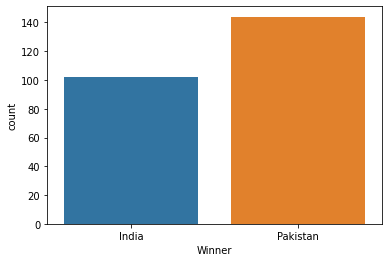

In [6]:
import seaborn as sns
sns.countplot(df['Winner'])

In [7]:
df.isna().sum().sort_values()

Unnamed: 0       0
Scorecard        0
Team_1           0
Team_2           0
Margin           0
Ground           0
Match_Date       0
Winner           0
Venue_Team1      0
Venue_Team2      0
Innings_Team1    0
Innings_Team2    0
Host_Country     8
dtype: int64

In [0]:
df = df.fillna('Missing')

In [9]:
df.isna().sum().sort_values()

Unnamed: 0       0
Scorecard        0
Team_1           0
Team_2           0
Margin           0
Ground           0
Match_Date       0
Winner           0
Host_Country     0
Venue_Team1      0
Venue_Team2      0
Innings_Team1    0
Innings_Team2    0
dtype: int64

# New Features

In [0]:
df['played_at_home'] = (df['Host_Country'] == 'India')

In [0]:
df['played_at_Pakistan'] = (df['Host_Country'] == 'Pakistan')

In [0]:

df['Played_in_neutral'] = (df['Host_Country'] != 'India') & (df['Host_Country'] != 'Pakistan')

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
train, test = train_test_split(df, train_size = .8, test_size = .2,
                               stratify = df['Winner'], random_state =42)

In [0]:
train, val = train_test_split(train, train_size = .8, test_size = .2,
                              stratify = train['Winner'], random_state =42)

# Feature selection

In [0]:
target = 'Winner'

In [17]:
train.describe(exclude = 'number').T.sort_values(by = 'unique', ascending = False)

,count,unique,top,freq
Scorecard,156,109,ODI # 1115,2
Match_Date,156,109,"Mar 18, 2012",2
Ground,156,41,Sharjah,29
Host_Country,156,11,India,38
Venue_Team1,156,3,Neutral,94
Venue_Team2,156,3,Neutral,94
Team_1,156,2,India,85
Team_2,156,2,Pakistan,85
Margin,156,2,Winner1stInning,84
Winner,156,2,Pakistan,92


In [0]:
# Removing columns with high cordinality
high_cardinality = 'Scorecard', 'Match_Date'
# Margin will cause data leakage
features = train.columns.drop(['Unnamed: 0', 'Winner', 'Scorecard', 'Match_Date', 'Margin'])

In [0]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [20]:
pip install --upgrade category_encoders

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.1.0)


In [0]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

In [22]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names= True),
    RandomForestClassifier(random_state = 42)

)
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Team_1', 'Team_2', 'Ground',
                                     'Host_Country', 'Venue_Team1',
                                     'Venue_Team2', 'Innings_Team1',
                                     'Innings_Team2'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=

# Validation accuracy

In [0]:
from sklearn.metrics import accuracy_score

In [0]:
y_pred_val = pipeline.predict(X_val)

In [25]:
accuracy_score(y_val, y_pred_val)

0.625

# Test accuracy

In [0]:
y_pred_test = pipeline.predict(X_test)

In [27]:
accuracy_score(y_test, y_pred_test)

0.5

# xgboost

In [0]:
from xgboost import XGBClassifier

In [29]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names= True),
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)

)
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Team_1', 'Team_2', 'Ground',
                                     'Host_Country', 'Venue_Team1',
                                     'Venue_Team2', 'Innings_Team1',
                                     'Innings_Team2'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=-1, nthread=None,
                      

# Validation accuracy with xgboost

In [0]:
y_pred_val = pipeline.predict(X_val)

In [31]:
accuracy_score(y_val, y_pred_val)

0.6

# Test accuracy with xgboost

In [0]:
y_pred_test = pipeline.predict(X_test)

In [33]:
accuracy_score(y_test, y_pred_test)

0.56

In [0]:
# little better

# Installing eli5

In [35]:
!pip install eli5

# Getting permutation importance

In [36]:
transformers = make_pipeline(
    ce.OrdinalEncoder() 
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [37]:
import eli5
from eli5.sklearn import PermutationImportance



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [38]:
permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              learning_rate=0.1,
                                              max_delta_step=0, max_depth=3,
                                              min_child_weight=1, missing=None,
                                              n_estimators=100, n_jobs=-1,
                                              nthread=None,
                                              objective='binary:logistic',
                                              random_state=42, reg_alpha=0,
                                              reg_lambda=1, scale_pos_weight=1,
                                              seed=None, silent=None,
                   

In [39]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

Innings_Team1        -0.045
Played_in_neutral    -0.025
Team_1               -0.015
Venue_Team1          -0.005
Team_2                0.000
Venue_Team2           0.000
Innings_Team2         0.000
played_at_home        0.000
played_at_Pakistan    0.005
Ground                0.015
Host_Country          0.030
dtype: float64